# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import seaborn as sns

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
int(df.groupby('email').count()['article_id'].median())

3

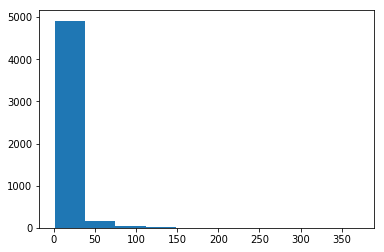

In [4]:
user_view = df.groupby('email').count()['article_id']
step = np.ceil((user_view.max() - user_view.min()) / 10)
bins = np.arange(user_view.min(), user_view.max() + step, step)
plt.hist(df.groupby('email').count()['article_id'], bins=bins);

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = int(df.groupby('email').count()['article_id'].median())
max_views_by_user = user_view.max()

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
df_content.shape

(1056, 5)

In [7]:
# Find and explore duplicate articles
df_content[df_content.duplicated('article_id')]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


5 dupilcated articles detected.

In [3]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset = 'article_id', inplace=True)
df_content.shape

(1051, 5)

All duplicated articles have been removed.

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [9]:
# a.The number of unique articles that have an interaction with a user
len(df.groupby('article_id').count()['title'])

714

In [10]:
# b.The number of unique articles in the dataset (whether they have any interactions or not)
df_content.shape[0]

1051

In [11]:
# c.The number of unique users in the dataset. (excluding null values) 
df.email.nunique()

5148

In [12]:
# d.The number of user-article interactions in the dataset
df.shape[0]

45993

In [13]:
unique_articles = len(df.groupby('article_id').count()['title'])
total_articles = df_content.shape[0]
unique_users = df.email.nunique()
user_article_interactions = df.shape[0]

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [14]:
# The most viewed article in the dataset as a string with one value following the decimal 
str(df.groupby('article_id').count()['title'].sort_values(ascending=False).index[0])

'1429.0'

In [15]:
# The most viewed article in the dataset was viewed how many times?
df.groupby('article_id').count()['email'].max()

937

In [16]:
most_viewed_article_id = str(df.groupby('article_id').count()['title'].sort_values(ascending=False).index[0])
max_views = df.groupby('article_id').count()['title'].max()

In [4]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [18]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [7]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    title_viewed = df.groupby('title').count()['user_id']
    top_articles = list(title_viewed.sort_values(ascending=False).index[: n])
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    
    '''
    # Your code here
    top_articles = get_top_articles(n)
    top_articles_ids = [df.article_id[np.where(df.title == t)[0][0]] for t in top_articles]
     
    return top_articles_ids # Return the top article ids

In [9]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [10]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [22]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    n_atc = df.article_id.nunique() # number of articles
    atc_id = df.article_id.sort_values().unique()
    
    n_user = df.user_id.nunique()# number of users
    user_id = df.user_id.sort_values().unique()
    
    # create an empty dataframe
    user_item = pd.DataFrame(np.zeros((n_user, n_atc)), index = user_id, columns = atc_id)
    
    # iterate through each row 
    for i in range(n_user):
        atc_list = list(df[df.user_id == user_id[i]].article_id) # pull each user's interacted articles' ids
        for j in atc_list:
            atc_idx = np.where(atc_id == j)[0][0]
            user_item.iloc[i, atc_idx] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [23]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [24]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    user1_sim = [] # a list to store similar users
    
    user1_idx = np.where(user_item.index == user_id)[0][0]
    
    for user2_idx in range(user_item.shape[0]):
        user1_atc = user_item.iloc[user1_idx] # Pull the article array of the input user
        user2_id = user_item.index[user2_idx]
        user2_atc = user_item.iloc[user2_idx] # Pull the article array of the compared user
        
        dist = np.dot(user1_atc, user2_atc.transpose()) # calculate the euclidean dist
        user1_sim.append((user2_id, dist))
    
    user1_sim = pd.DataFrame(user1_sim, columns=['user2_id', 'dist'])
    # sort by similarity
    user1_sim.sort_values(by = 'dist', ascending=False, inplace=True)

    # create list of user2 ids
    most_similar_users = list(user1_sim.user2_id)
    
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [25]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [26]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = [] # a list to store article names
    for atc in article_ids:
        idx = np.where(df.article_id == float(atc))[0][0]
        article_names.append(df.title[idx])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = [str(x) for x in user_item.loc[user_id][user_item.loc[user_id] > 0].index]
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommended article ids for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    atc_seen_ids, _ = get_user_articles(user_id) # Pull articles the user has interacted with
    recs = []
    
    for user in find_similar_users(user_id):
        new_ids, _ = get_user_articles(user)
        new_recs = np.setdiff1d(new_ids, atc_seen_ids, assume_unique=True)
        recs = np.unique(np.concatenate([new_recs, recs], axis=0))
        
        if len(recs) > m-1: # jump out of loop since the length of list larger than required
            break
            
    recs = recs[: m] # return first m article ids
    return recs # return your recommendations for this user_id    

In [27]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [28]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [29]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    user1_sim = [] # a list to store similar users
    
    user1_idx = np.where(user_item.index == user_id)[0][0]
    
    for user2_idx in range(user_item.shape[0]):
        user1_atc = user_item.iloc[user1_idx] # pull the article array of the input user
        user2_id = user_item.index[user2_idx]
        user2_atc = user_item.iloc[user2_idx] # pull the article array of the compared user
        
        dist = np.dot(user1_atc, user2_atc.transpose()) # calculate the euclidean dist
        num_int = int(user2_atc.sum()) # user2's number of article interaction
        user1_sim.append((user2_id, dist, num_int)) # store each user's id, similarity distance, number of interaction as a tuple
    
    neighbors_df = pd.DataFrame(user1_sim, columns=['neighbor_id', 'similarity', 'num_interactions'])
    neighbors_df = neighbors_df[neighbors_df['neighbor_id'] != user_id] # drop user_id row
    
    # sort by similarity and number of article interactions
    neighbors_df.sort_values(by = ['similarity', 'num_interactions'], ascending=False, inplace=True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10, df=df):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = [] # a list to store articles inteacted with similar users
    atc_seen_ids, _ = get_user_articles(user_id) # pull articles the user has interacted with      
    similar_user = get_top_sorted_users(user_id).neighbor_id # use new find function to get similiar users
    atc_num_int = df.groupby('article_id').count()['user_id'] # list article_id with number of interactions
    
    for user in similar_user:
        new_ids, _ = get_user_articles(user)
        new_recs = np.setdiff1d(new_ids, atc_seen_ids, assume_unique=True)
        for i in new_recs:
            num_int = atc_num_int[atc_num_int.index == float(i)].values[0]
            recs.append((float(i), num_int))
        
        if len(recs) > m-1: # jump out of loop since the length of list larger than required
            break
        
    recs_df = pd.DataFrame(recs, columns=['article_id', 'num_int'])
    recs_df.sort_values(by='num_int', ascending=False, inplace=True)
        
    recs = list(recs_df.article_id[: m])
    rec_names = get_article_names(recs)

    return recs, rec_names

In [30]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1429.0, 1330.0, 1314.0, 1293.0, 1162.0, 1271.0, 43.0, 1351.0, 1368.0, 1305.0]

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'analyze energy consumption in buildings', 'customer demographics and sales', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss', 'putting a human face on machine learning', 'gosales transactions for naive bayes model']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [31]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0]# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[10]# Find the 10th most similar user to user 131

### Actually I find in my dataframe, the answer of the 10th most similar user to uesr 131 in the project_tests.py is located 11th in my output. It confuses me that whether it is my mistake or the real question should be 11th most similar user? 

In [32]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

By far, I have worked out 2 recommendation functions:
1. get_top_articles/get_top_article_ids(number_of_article_to_recommend)
2. user_user_recs_part2(user_id, number_of_article_to_recommend)
---
- The first function is suitable in new user case. Because whether he/she registered or not, the engine can provide him/her some most popular articles.
- The second function can be worked to the new user only if he/she has registered.The new user will be allocated a unique user_id. Since there is no interaction from the new user to any article, all other users will have the same similarity to this new user. In my function, they will be ranked based on how many articles they have interacted with. So, it equals to guess the most active user shares interests with new user. If the guess is wrong, the recommendation engine works terribly.

__Better recommendation function discussion:__

The first function is not perfect. The indicator of the popular does not count on the factor of time. Which means, an earlier published article is more likely to gain more interactions than a later one. So if we only focus on the interaction number of each article, it will tend to recommend 'old' article to new users. Maybe some articles are high quality, and it has the possibility that some of the articles outmoded.
For a thorough technical community recommendation engine. The content we will recommend should give consideration to both quality and tendency.

The suggestion is to add a timestamp column of each email in the df dataframe. Then we can get which title is most hottest topic in recent or it is getting cold. We can split our cold start recommendation to new user into two parts. One part is based on the interaction number, the other is based on how many interactions happend in recent time (ex. two weeks). The ratio of two parts can be 50/50 at start. Then we track the new users' choice for a period time to see which part is more welcome. Based on the tracking result, the ratio of two parts can be adjusted.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [33]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here



In [34]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [ ]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [35]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [36]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [37]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

**Provide your response here.**

The user_item in the lesson is a matrix storing rating to the item by user. All the values in the matrix is numeric from 0 to 10 based on how user evaluate the item. For any item the user has not rated. It is not possible to use 0 to present since 0 is a number of the rating, so the cell presenting the relationship between user and item will be left with 'NaN'. Since any 'NaN' in the matrix will lead singular value decomposition to failure, the FunkSVD method will be used.

In the IBM case, our user_item only reflect whether the user and item has interaction. Every cell in the matrix stores the value using boolean. So there is no 'NaN' in the matrix, which provides the situation for singular value decomposition to work. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

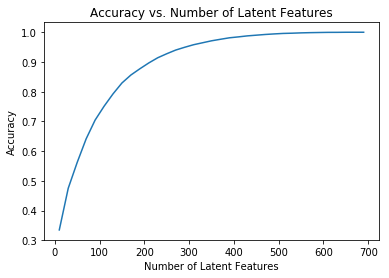

In [38]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [39]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [40]:
# How many users can we make predictions for in the test set?
user_can_pred = 0
for user in test_idx:
    if user in user_item_train.index:
        user_can_pred += 1

# How many users in the test set are we not able to make predictions for because of the cold start problem?
user_cant_pred = len(test_idx) - user_can_pred

# How many articles can we make predictions for in the test set?
atc_can_pred = 0
for atc in test_arts:
    if atc in user_item_train.columns:
        atc_can_pred += 1
        
# How many movies in the test set are we not able to make predictions for because of the cold start problem?
atc_cant_pred = len(test_arts) - atc_can_pred

print(user_can_pred, user_cant_pred, atc_can_pred, atc_cant_pred)

20 662 574 0


In [41]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [42]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

In [43]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

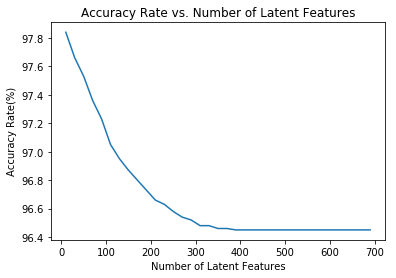

In [44]:
num_latent_feats = np.arange(10,700+10,20)
acc_rate = [] # store accurate rate in different latent feature scenario 

for k in num_latent_feats:
    tot_ct = 0 # count prediction number
    acc_ct = 0 # count correct prediction number
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

    for i in range(len(test_idx)): # iterate through test dataset user
        for j in range(len(test_arts)): # iterate through test dataset article
            if (test_idx[i] in user_item_train.index) & (test_arts[j] in user_item_train.columns):
                user_idx = np.where(user_item_train.index == test_idx[i])[0][0]
                atc_idx = np.where(user_item_train.columns == test_arts[j])[0][0]

                pred = np.round(np.dot(np.dot(u_new[user_idx, :], s_new), vt_new[:, atc_idx]))

                tot_ct +=1
                if pred == user_item_test.iloc[i, j]:
                    acc_ct +=1
    acc_rate.append(round(acc_ct / tot_ct * 100, 2)) # save accurate rate in each iteration

plt.plot(num_latent_feats, acc_rate);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy Rate(%)');
plt.title('Accuracy Rate vs. Number of Latent Features');

From the above figure, it can be summarized as: more features, lower accuracy rate.The result is just confused.

As a recommendation engine, we want it to provide more accurate suggestion. In this case, it equals to find more correct '1' between users and articles.

For the purpose, the better indicator could be precision or f1-score. To avoid arbitary guess, let's try it on two cases: 
- 1 latent feature
- 500 latent features

In [45]:
# define a function to help calculate precison, recall and f1-score
def prediction_prec_recall_f1(num_latent_feat):
    '''calculate prediction, recall, and f1-score of the training model as 
    target to predict correct '1' under different latent feature number situation
    
    INPUT:
    num_latent_feat - (int)Number of latent feature
    
    OUTPUT:
    actual_v_pred - numpay matrix stores actual value and predicted value counts
    precision - (float)count of correct prediction on 1 divided by count of total acutal 1
    recall - (float)count of correct prediction on 1 divided by count of total predict 1
    f1 - (float)f1 score based on precision and recall
    '''

    actual_v_pred = np.zeros((2,2)) # a matrix to store actual value and predicted value counts

    s_new, u_new, vt_new = np.diag(s_train[:num_latent_feat]), u_train[:, :num_latent_feat], vt_train[:num_latent_feat, :]

    for i in range(len(test_idx)): # iterate through test dataset user
        for j in range(len(test_arts)): # iterate through test dataset article
            if (test_idx[i] in user_item_train.index) & (test_arts[j] in user_item_train.columns):
                user_idx = np.where(user_item_train.index == test_idx[i])[0][0]
                atc_idx = np.where(user_item_train.columns == test_arts[j])[0][0]

                pred = np.round(np.dot(np.dot(u_new[user_idx, :], s_new), vt_new[:, atc_idx]))
                act = 1 - user_item_test.iloc[i, j]

                actual_v_pred[int(act), int(pred)]+=1
    
    precision = round(actual_v_pred[0,1]/actual_v_pred[:, 1].sum(), 4)
    recall = round(actual_v_pred[0,1]/actual_v_pred[1].sum(), 4)
    if (precision == 0) & (recall == 0): # in case no correct 1 get, F1 will return as 0
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)

    return actual_v_pred, precision, recall, f1

Precison is 0.0
Recall is 0.0
F1-score is 0


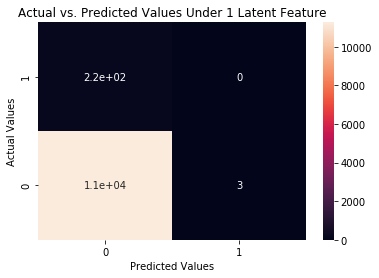

In [46]:
# with 1 latent feature
avp_1, p_1, r_1, f1_1 = prediction_prec_recall_f1(1)

sns.heatmap(avp_1, annot=True);
plt.xticks([0.5, 1.5], [0, 1]);
plt.yticks([0.5, 1.5], [1, 0]);
plt.xlabel("Predicted Values");
plt.ylabel("Actual Values");
plt.title("Actual vs. Predicted Values Under 1 Latent Feature");

print(f'Precison is {p_1}')
print(f'Recall is {r_1}')
print(f'F1-score is {f1_1}')

Precison is 0.1107
Recall is 0.0024
F1-score is 0.0046981432360742705


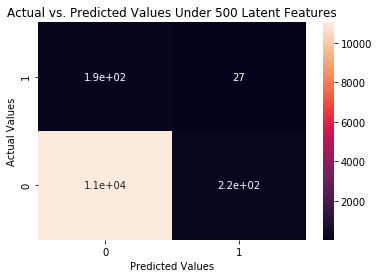

In [47]:
# with 500 latent features
avp_500, p_500, r_500, f1_500 = prediction_prec_recall_f1(500)

sns.heatmap(avp_500, annot=True);
plt.xticks([0.5, 1.5], [0, 1]);
plt.yticks([0.5, 1.5], [1, 0]);
plt.xlabel("Predicted Values");
plt.ylabel("Actual Values");
plt.title("Actual vs. Predicted Values Under 500 Latent Features");
    
print(f'Precison is {p_500}')
print(f'Recall is {r_500}')
print(f'F1-score is {f1_500}')

It seems the guessing is right. There shows Simpson's Paradox on accuracy rate.

Then let's see how the precison, recall and f1-score figure change through the number of latent feature change

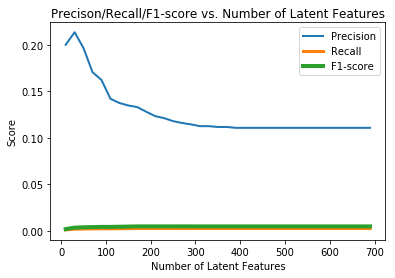

In [48]:
num_latent_feats = np.arange(10,700+10,20)
precs = [] # store precision figure
recalls = [] # store recall figure
f1s = [] # store f1-score figure

for k in num_latent_feats:
    _, prec, recall, f1 = prediction_prec_recall_f1(k)
    precs.append(prec)
    recalls.append(recall)
    f1s.append(f1)
    
lines = plt.plot(num_latent_feats, precs, num_latent_feats, recalls, num_latent_feats, f1s);
plt.setp(lines[0], linewidth=2)
plt.setp(lines[1], linewidth=3)
plt.setp(lines[2], linewidth=4)
plt.xlabel('Number of Latent Features');
plt.legend(('Precision', 'Recall', 'F1-score'), loc=0)
plt.ylabel('Score');
plt.title('Precison/Recall/F1-score vs. Number of Latent Features');

The shape of precision is much better than the one of accuracy rate

It goes up with more latent features at first and then dropped with too much features(over-fitting).

So let's do a deeper look at what is the best feature number for in a smaller range

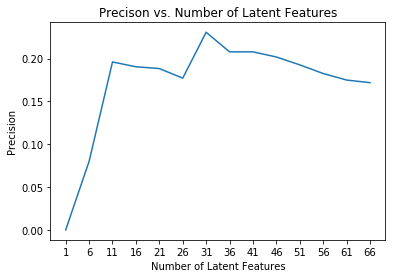

In [49]:
num_latent_feats = np.arange(1,71,5)
precs = [] # store precision figure

for k in num_latent_feats:
    _, prec, recall, f1 = prediction_prec_recall_f1(k)
    precs.append(prec)
    
plt.plot(num_latent_feats, precs);
plt.xticks(np.arange(1,71,5), np.arange(1,71,5))
plt.xlabel('Number of Latent Features');
plt.ylabel('Precision');
plt.title('Precison vs. Number of Latent Features');

It seems 31 latent features are almost the best precision recoreder

Precison is 0.2308
Recall is 0.0019
F1-score is 0.003768972926514826


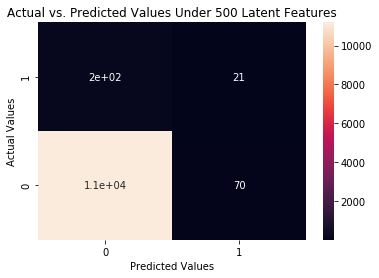

In [50]:
avp_31, p_31, r_31, f1_31 = prediction_prec_recall_f1(31)
sns.heatmap(avp_31, annot=True);
plt.xticks([0.5, 1.5], [0, 1]);
plt.yticks([0.5, 1.5], [1, 0]);
plt.xlabel("Predicted Values");
plt.ylabel("Actual Values");
plt.title("Actual vs. Predicted Values Under 500 Latent Features");
    
print(f'Precison is {p_31}')
print(f'Recall is {r_31}')
print(f'F1-score is {f1_31}')

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

Frankly speaking, the SVD model doesn't work well on precisely predict which article will the user like.
There is only 23% precentage to guess right. Which means the system would better to recommend at least 5 articles to user at once and the user can find one article he/she like.

On the other hand, compared with just give latest articles, a combination of above four recommendation method could be use to make an A/B test. The test scheme could be:
- Test A: 95% traffic with current recommendation scheme (track the interaction record for new user and normal user separately)
- Test B: 5% traffic with the scheme below (track the interaction record)
    - For new user (10 articles every time, not repetitive):
        - a. 50% from ranked most popular articles (track sole interaction)
        - b. 50% from hottest articles in recent 2 weeks (import timestamp of interaction, track sole interaction)
    - For normal user (12 articles every time, not repetitive):
        - c. 33% from hottest articles in recent 2 weeks (import timestamp of interaction into algorithm, track sole interaction)
        - d. 33% similar neighbors' popular articles (track sole interaction)
        - e. 33% SVD modeling prediction recommendation (track sole interaction)

After the test period:
- Compare new user:
    - Test A total average interaction
    - Test B total average interaction 
    - Test B a category article average interaction
    - Test B b category article average interaction
- Compare nomal user:
    - Test A total average interaction
    - Test B total average interaction
    - Test B c category article average interaction
    - Test B d category article average interaction
    - Test B e category article average interaction
    
If Test B total average interaction has statistical significant against Test A, publish the new recommendation version. Within Test B data, check which category recommendation has a better performance and raise its weight

If Test B total average interaction has no statistical significant against Test A, check each category recommendation's average interaction to see if some category has statistical significant against other's. Then run another round A/B testing with this category or these categories weights up

If all indicators from Test B have no statistical significant against Test A, try introduce new features to repeat above procedurs. For example:
- Use NLP or collect user contribution to classify articles with tags
- Classify interaction from user with articles into like, leave comment and just read

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0